In [1]:
#pip install tslearn

Note: you may need to restart the kernel to use updated packages.


In [3]:
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn import metrics

In [5]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.22.1.


### About K-Shape 

K-Shape is very similar to k-means. The difference is that the k-shape algorithm leverages the knowledge that our data point is time series. With time series, we have more room to operate.

The authors of the K-shape proposes to use the cross-correlation as the building block the distance measure. To some extent, with this set-up, we are actually introducing more data than what we original have. The alignment of time series can be considered as adjusting the some kind of "phase". It adds an extra dimension to the data point. Instead of a point, now we have an arrow with direction and it can spin.

# Import data


In [6]:
df_z = pd.read_parquet('../common/covid_cases_z_trans.parquet')

In [4]:
#df_case_per_popu = pd.read_parquet('../common/cases_per_popu_mod.parquet')

In [7]:
df_z.head(1)

,Algeria,Argentina,Australia,Austria,Bangladesh,Belarus,Belgium,Bolivia,Bulgaria,Canada,...,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Vietnam,Zambia,Zimbabwe
2020-03-01,-1.016766,-0.704723,-1.314497,-2.128248,-0.974537,-1.38328,-2.021154,-0.852664,-0.982762,-1.692528,...,-0.994483,-1.677526,-0.977963,-1.334201,-1.82876,-1.206989,-1.733456,-1.337746,-0.739615,-0.683331


In [8]:
df_trans = df_z.T

In [9]:
df_array = df_trans.to_numpy()

In [10]:
df_array.shape

(81, 201)

# Clustering with z-transpose

Parameters for K-Shape: 
n_clusters (default:3): number of clusters

max_iter (default:100): maximum number of iterations of the algorithm

tol (default:1e-6): Inertia variation threshold. If at some point, inertia varies less than this threshold between two consecutive iterations, the model is considered to have converged and the algorithm stops.

n_init (default:1): Number of time the k-Shape algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

verbose (default: false): whether or not to print information about the inertia while learning the model.

random_state: Generator used to initialize the centers. If an integer is given, it fixes the seed. Defaults to the global numpy random number generator.

init: Method for initialization. ‘random’: choose k observations (rows) at random from data for the initial centroids. If an ndarray is passed, it should be of shape (n_clusters, ts_size, d) and gives the initial centers.

In [11]:
seed = 0
np.random.seed(seed)

ks = KShape(n_clusters=4, n_init=100, random_state=seed)
y_pred = ks.fit_predict(df_array)

In [12]:
ks.cluster_centers_.shape

(4, 201, 1)

In [13]:
a1=df_trans.loc[y_pred==0].transpose()
a2=df_trans.loc[y_pred==1].transpose()
a3=df_trans.loc[y_pred==2].transpose()
a4=df_trans.loc[y_pred==3].transpose()

In [13]:
#a1.to_parquet('../common/clustering_results/df_kshape_z_0.parquet')
#a2.to_parquet('../common/clustering_results/df_kshape_z_1.parquet')
#a3.to_parquet('../common/clustering_results/df_kshape_z_2.parquet')
#a4.to_parquet('../common/clustering_results/df_kshape_z_3.parquet')

In [14]:
print("Countries in cluster 0:", np.count_nonzero(y_pred == 0))
print("Countries in cluster 1:", np.count_nonzero(y_pred == 1))
print("Countries in cluster 2:", np.count_nonzero(y_pred == 2))
print("Countries in cluster 3:", np.count_nonzero(y_pred == 3))

Countries in cluster 0: 31
Countries in cluster 1: 17
Countries in cluster 2: 22
Countries in cluster 3: 11


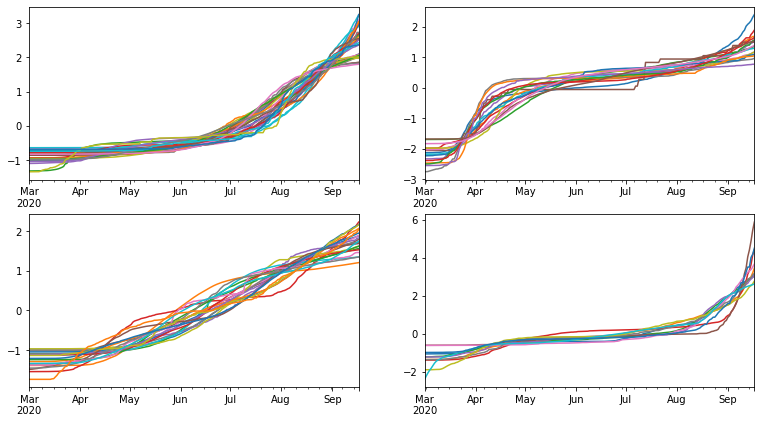

In [15]:
#Make a figure with the four clusters
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(13, 7)
a1.plot(legend='', ax=axes[0,0])
a2.plot(legend='', ax=axes[0,1])
a3.plot(legend='', ax=axes[1,0])
a4.plot(legend='', ax=axes[1,1])

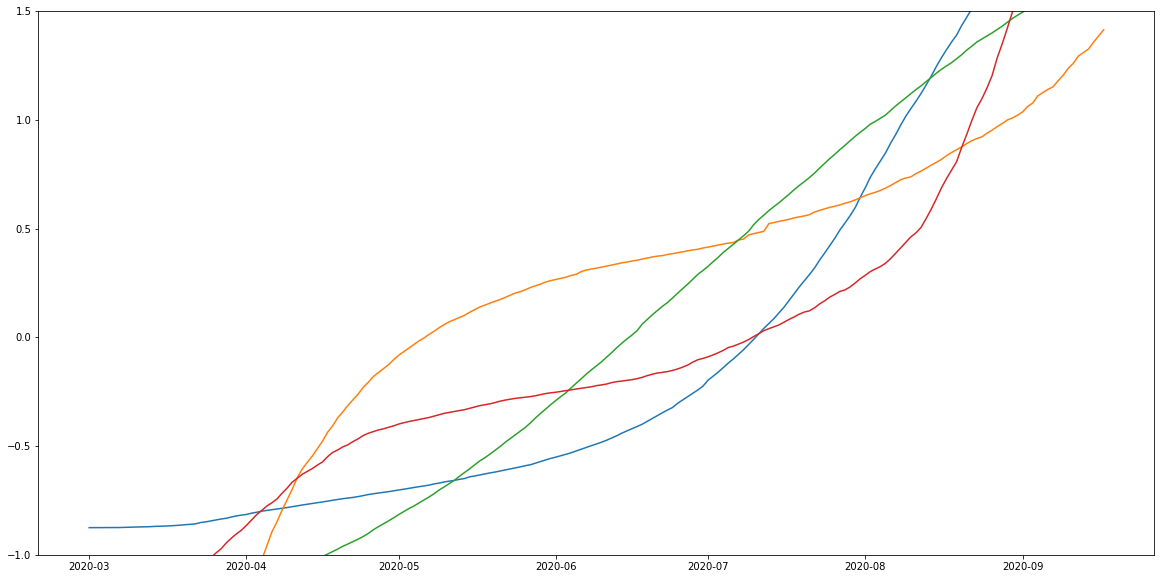

In [16]:
plt.figure(figsize=(20,10))
plt.plot(a1.mean(axis=1), label='')
plt.plot(a2.mean(axis=1), label='')
plt.plot(a3.mean(axis=1), label='')
plt.plot(a4.mean(axis=1), label='')
plt.ylim(-1, 1.5)
plt.show()

In [17]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

In [18]:
x_ks = df_z.T.iloc[:,:].values

In [19]:
label_ks = []
for idx in df_z.T.index:
    if idx in list(a1.columns):
        label_ks.append(1)
    elif idx in list(a2.columns):
        label_ks.append(2)
    elif idx in list(a3.columns):
        label_ks.append(3)
    elif idx in list(a4.columns):
        label_ks.append(4)
    else:
        print("ERROR: ", idx)

### *Silhouette score*

In [20]:
silhouette_score = silhouette_score(x_ks, labels=label_ks, metric='euclidean')

In [21]:
print("K-shape silhouette_score: ", silhouette_score)

K-shape silhouette_score:  0.3566102811121223


### **davies_bouldin_score**

In [22]:
davies_bouldin_score = davies_bouldin_score(x_ks, labels=label_ks)

In [23]:
print("K-shape davies_bouldin_score: ", davies_bouldin_score)

K-shape davies_bouldin_score:  0.9861124002265622


### **calinski_harabasz_score**

In [24]:
calinski_harabasz_score = calinski_harabasz_score(x_ks, labels=label_ks)

In [25]:
print("K-shape calinski_harabasz_score: ", calinski_harabasz_score)

K-shape calinski_harabasz_score:  65.91231843710642


### K-Shape on cases/population

In [16]:
ks_cp = KShape(n_clusters=4, n_init=5, verbose=True, random_state=seed).fit(df_case_per_popu.T)
y_pred = ks.fit_predict(df_array)

Init 1
0.158 --> 0.159 --> 
Init 2
0.158 --> 0.155 --> 0.155 --> 0.155 --> 0.155 --> 
Init 3
0.161 --> 0.161 --> 
Init 4
0.161 --> 0.161 --> 0.162 --> 
Init 5
0.161 --> 0.160 --> 0.160 --> 0.161 --> 
Init 1
0.001 --> 0.001 --> 0.001 --> 
Init 2
0.001 --> 0.001 --> 0.001 --> 
Init 3
0.002 --> 0.001 --> 0.001 --> 0.001 --> 
Init 4
0.002 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 
Init 5
0.002 --> 0.002 --> 0.001 --> 0.001 --> 0.001 --> 


In [17]:
labels_cp = ks_cp.labels_[:]
labels_cp

array([0, 3, 3, 1, 0, 1, 1, 0, 0, 1, 0, 3, 3, 3, 2, 3, 1, 0, 0, 0, 1, 3,
       1, 1, 2, 0, 3, 2, 1, 3, 3, 0, 3, 1, 3, 1, 3, 0, 3, 0, 1, 2, 2, 0,
       1, 3, 0, 3, 3, 3, 3, 1, 0, 1, 0, 0, 0, 3, 0, 3, 0, 1, 3, 1, 3, 0,
       0, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1, 0, 3, 1, 3, 3, 1, 1, 0, 2, 3, 3,
       3], dtype=int64)

In [18]:
print("Countries in cluster 0:", np.count_nonzero(y_pred == 0))
print("Countries in cluster 1:", np.count_nonzero(y_pred == 1))
print("Countries in cluster 2:", np.count_nonzero(y_pred == 2))
print("Countries in cluster 3:", np.count_nonzero(y_pred == 3))

Countries in cluster 0: 20
Countries in cluster 1: 16
Countries in cluster 2: 29
Countries in cluster 3: 24
